# Earning Potential Intelligence System (EPIS)

### Problem Statement
Manual identification of high-income individuals is inefficient and error-prone.  
This project aims to build a machine learning classification model that predicts whether an individual earns **more than 50K per year** or **50K or less**, based on demographic data.

### Objective
- Predict income category (`<=50K` or `>50K`)
- Apply effective data preprocessing and feature engineering
- Build and evaluate a classification model

## Dataset Overview

The dataset contains demographic and employment-related information such as:
- Age
- Education level
- Occupation
- Work class
- Capital gain and loss
- Weekly working hours

**Target Variable:**  
- `earning_potential`  
  - `<=50K`
  - `>50K`

The dataset includes:
- Missing values
- Skewed numerical features
- Both categorical and numerical data


In [1]:
#importing all required libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
#raw data loading
column_names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                                          'relationship','race','sex','capital_gain','capital_loss','working_hours','country','earning_potential']
adult_raw = pd.read_csv('adult.csv',header=None,names=column_names,skipinitialspace=True,na_values=['?'])
adult_raw.describe()

,age,fnlwgt,education-num,capital_gain,capital_loss,working_hours
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Exploratory Data Analysis (EDA)

### Target Variable Distribution
The target variable shows a **75:25 class imbalance**, where:
- 75% of individuals earn `<=50K`
- 25% earn `>50K`

Due to this imbalance:
- Accuracy alone can be misleading
- Precision, Recall, and F1-score are also considered during evaluation


In [3]:
print(adult_raw['earning_potential'].value_counts()/len(adult_raw['earning_potential']))

#checking for inconsistencies
for i in column_names:
   print(adult_raw[i].value_counts())

#check for if any negative numeric value
check_negative = ['age','education-num','working_hours']

for i in check_negative:
   adult_raw[i] = adult_raw[i].apply(lambda x: x if x >= 0 else np.nan)

alpha_cols = ['workclass','education','marital-status','occupation',
             'relationship','sex','race','country']


#found duplicate name in gender
print(adult_raw.duplicated().sum())
adult_raw.drop_duplicates(inplace=True)

#changing all alphabetical data to lowercase
for i in alpha_cols:
   adult_raw[i] = adult_raw[i].str.strip().str.lower()

#mapping target feature to binary category
adult_raw['earning_potential'] = adult_raw['earning_potential'].apply(
   lambda x: 0 if x == '<=50K' else 1
)



earning_potential
<=50K    0.75919
>50K     0.24081
Name: count, dtype: float64
age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
fnlwgt
123011    13
164190    13
203488    13
121124    12
126675    12
          ..
316185     1
292353     1
205019     1
180296     1
422249     1
Name: count, Length: 21648, dtype: int64
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th        

## Numerical Feature Analysis

Numerical columns include:
- age
- fnlwgt
- education-num
- working_hours
- capital_gain
- capital_loss

### Observations
- Most numerical features are **right-skewed**
- `capital_gain` and `capital_loss` contain many zero values with few extremely high values
- Such distributions indicate **meaningful financial signals rather than data errors**


In [4]:
print(adult_raw[['working_hours','earning_potential']].corr().iloc[0,1])
print(adult_raw[['age','earning_potential']].corr().iloc[0,1])
print(adult_raw[['fnlwgt','earning_potential']].corr().iloc[0,1])
print(adult_raw[['education-num','earning_potential']].corr().iloc[0,1])
print(adult_raw[['capital_gain','earning_potential']].corr().iloc[0,1])
print(adult_raw[['capital_loss','earning_potential']].corr().iloc[0,1])

0.22965810163854825
0.2340370946445635
-0.009502349300418206
0.33527151224893026
0.22333649892036503
0.15050076536805385


In [6]:
results = []
for col in alpha_cols:
   contingency = pd.crosstab(adult_raw[col], adult_raw['earning_potential'])
   chi2, p, dof, expected = chi2_contingency(contingency)
   n = contingency.values.sum()
   min_dim = min(contingency.shape) - 1
   cramers_v = np.sqrt(chi2 / (n * min_dim))
   results.append({'Feature': col, 'Chi2': chi2, 'p-value': p, 'Cramers_V': cramers_v})

for i in results:
   for k,v in i.items():
       print(k,':',v)
   print('-'*40)


Feature : workclass
Chi2 : 922.3498477209453
p-value : 7.156800770833626e-195
Cramers_V : 0.16836781914218513
----------------------------------------
Feature : education
Chi2 : 4428.404687554787
p-value : 0.0
Cramers_V : 0.3689222912649586
----------------------------------------
Feature : marital-status
Chi2 : 6510.332126761207
p-value : 0.0
Cramers_V : 0.447314337676062
----------------------------------------
Feature : occupation
Chi2 : 3197.612778407624
p-value : 0.0
Cramers_V : 0.3134903536212152
----------------------------------------
Feature : relationship
Chi2 : 6692.09880313626
p-value : 0.0
Cramers_V : 0.45351579634155065
----------------------------------------
Feature : sex
Chi2 : 1516.5397108545465
p-value : 0.0
Cramers_V : 0.2158927904925206
----------------------------------------
Feature : race
Chi2 : 330.94339926366814
p-value : 2.2797874171824478e-70
Cramers_V : 0.1008528343491578
----------------------------------------
Feature : country
Chi2 : 315.3720987639804
p-

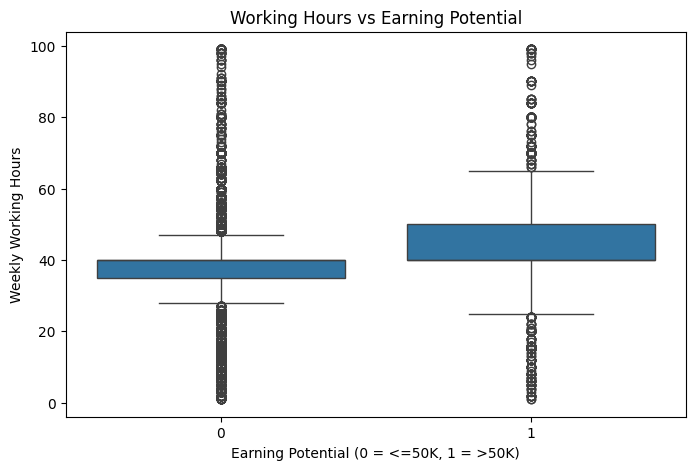

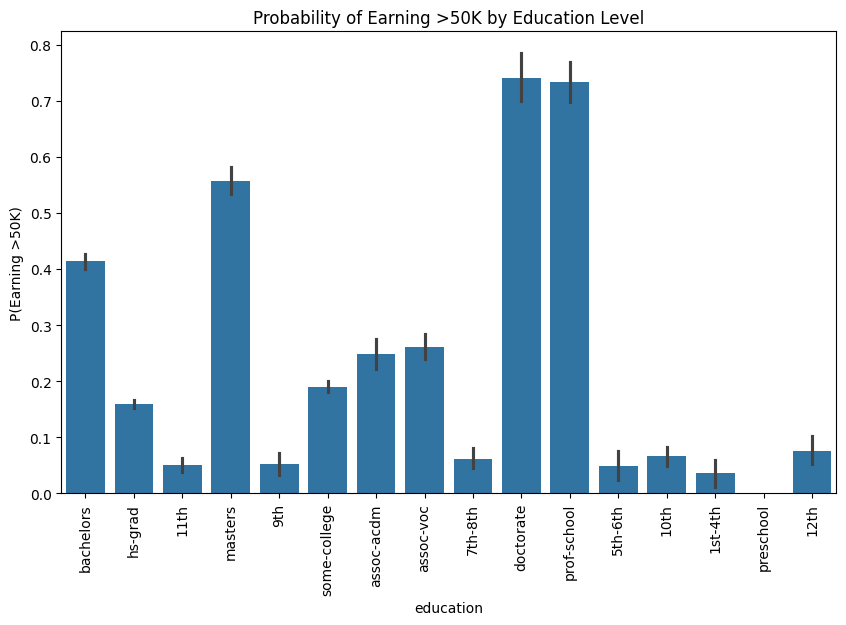

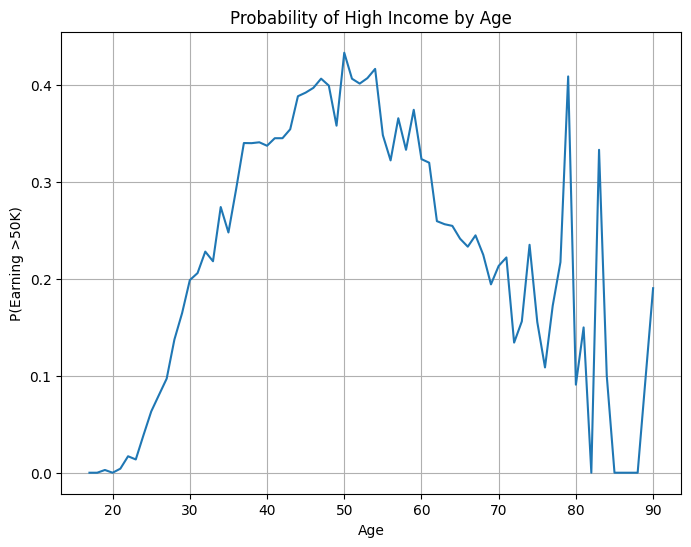

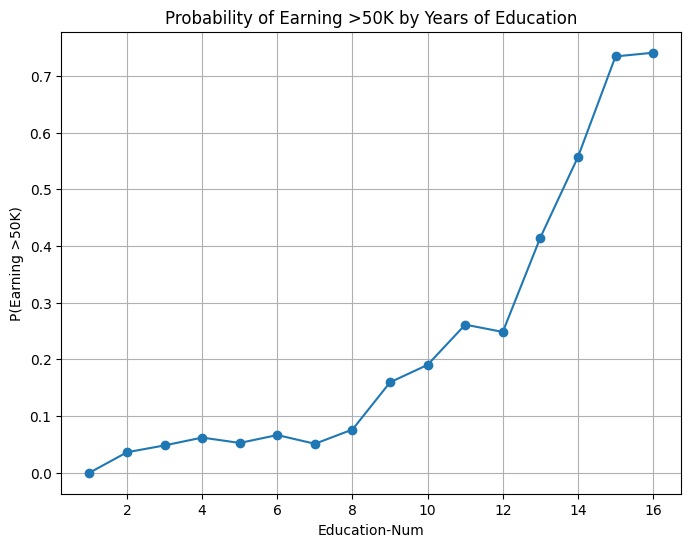

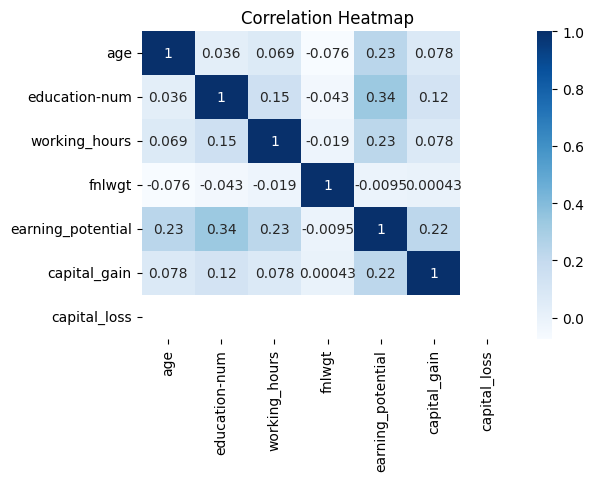

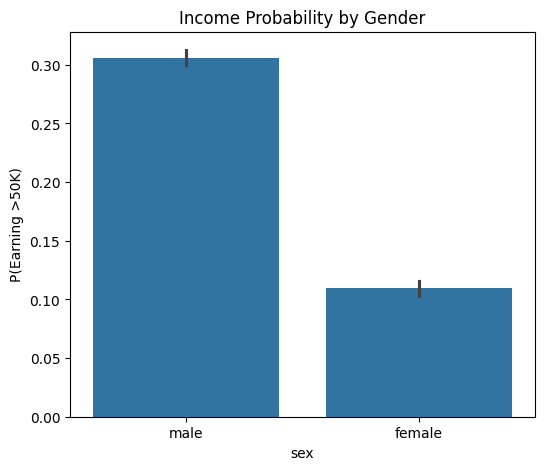

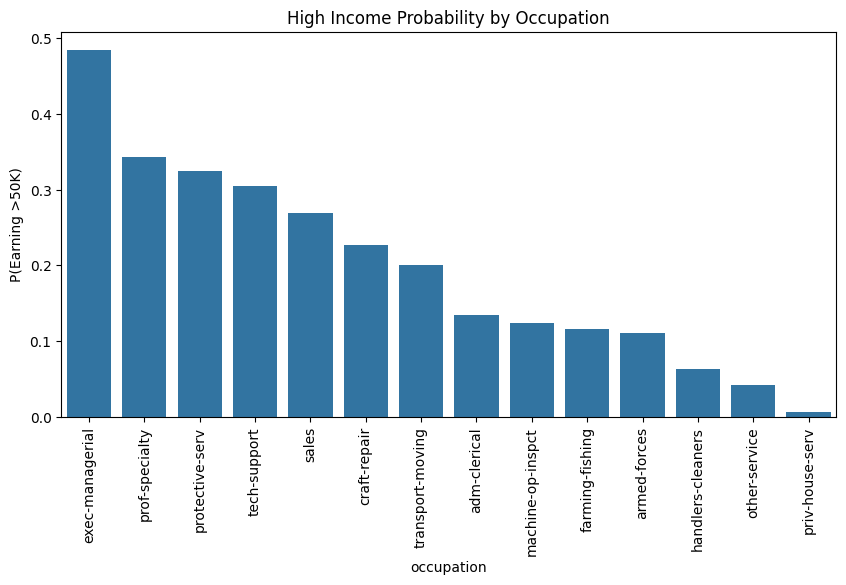

In [11]:

plt.figure(figsize=(8,5))
sns.boxplot(x=adult_raw['earning_potential'], y=adult_raw['working_hours'])
plt.xlabel("Earning Potential (0 = <=50K, 1 = >50K)")
plt.ylabel("Weekly Working Hours")
plt.title("Working Hours vs Earning Potential")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    data=adult_raw,
    x='education',
    y='earning_potential',
    estimator=lambda x: sum(x)/len(x)
)
plt.xticks(rotation=90)
plt.title("Probability of Earning >50K by Education Level")
plt.ylabel("P(Earning >50K)")
plt.show()

plt.figure(figsize=(8,6))
adult_raw.groupby('age')['earning_potential'].mean().plot()
plt.title("Probability of High Income by Age")
plt.ylabel("P(Earning >50K)")
plt.xlabel("Age")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
education_income = adult_raw.groupby('education-num')['earning_potential'].mean()

plt.plot(education_income.index, education_income.values, marker='o')
plt.title("Probability of Earning >50K by Years of Education")
plt.xlabel("Education-Num")
plt.ylabel("P(Earning >50K)")
plt.grid(True)
plt.show()



plt.figure(figsize=(6,4))
sns.heatmap(
    adult_raw[['age','education-num','working_hours','fnlwgt','earning_potential','capital_gain','capital_loss']].corr(),
    annot=True, cmap='Blues'
)
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(
    data=adult_raw,
    x='sex',
    y='earning_potential'
)
plt.title("Income Probability by Gender")
plt.ylabel("P(Earning >50K)")
plt.show()

plt.figure(figsize=(10,5))
occupation_income = adult_raw.groupby('occupation')['earning_potential'].mean().sort_values(ascending=False)

sns.barplot(x=occupation_income.index, y=occupation_income.values)
plt.xticks(rotation=90)
plt.title("High Income Probability by Occupation")
plt.ylabel("P(Earning >50K)")
plt.show()


## Outlier Detection and Treatment

Outliers were detected using the **Interquartile Range (IQR)** method for most numerical features.

### Approach
- Values outside the range:  
  `Q1 - 1.5 × IQR` and `Q3 + 1.5 × IQR`  
  were treated as outliers.
- Detected outliers were replaced with `NaN`.

### Important Decision
`capital_gain` and `capital_loss` were **not treated as outliers** in the final model.

### Reasoning
- These features are naturally skewed
- High values represent real financial gains or losses
- Removing them caused loss of predictive information and reduced model accuracy

This decision improved overall model performance.


## Missing Value Imputation

### Numerical Features
- Missing values were imputed using the **median**
- Median is preferred over mean because:
  - Numerical features are skewed
  - Median is robust to extreme values

### Categorical Features
- Missing values were filled using the **mode**
- Mode preserves the most frequent category


age: Q1=28.0, Q3=48.0, IQR=20.0, Lower=-2.0, Upper=78.0
fnlwgt: Q1=117827.0, Q3=236993.0, IQR=119166.0, Lower=-60922.0, Upper=415742.0
education-num: Q1=9.0, Q3=12.0, IQR=3.0, Lower=4.5, Upper=16.5
working_hours: Q1=40.0, Q3=45.0, IQR=5.0, Lower=32.5, Upper=52.5
capital_gain: Q1=0.0, Q3=0.0, IQR=0.0, Lower=0.0, Upper=0.0
capital_loss: Q1=0.0, Q3=0.0, IQR=0.0, Lower=0.0, Upper=0.0


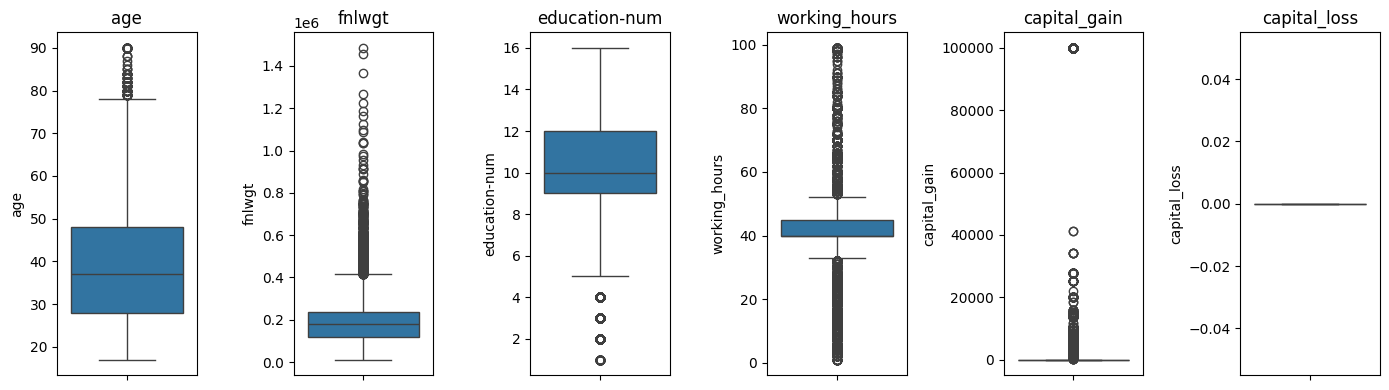

In [5]:
# finding outliers
numeric_cols1 = ['age','fnlwgt', 'education-num', 'working_hours','capital_gain','capital_loss']
outlier_bounds = {}

for col in numeric_cols1:
   Q1 = adult_raw[col].quantile(0.25)
   Q3 = adult_raw[col].quantile(0.75)
   IQR = Q3 - Q1
   lower = Q1 - 1.5 * IQR
   upper = Q3 + 1.5 * IQR

  
   
   print(f"{col}: Q1={Q1}, Q3={Q3}, IQR={IQR}, Lower={lower}, Upper={upper}")

#removing outliers
removal = ['fnlwgt']
for i in removal:
    adult_raw[col] = adult_raw[col].apply(
       lambda x: x if (x >= lower and x <= upper) else np.nan
   )
# Filling numeric columns
for col in numeric_cols1:
    adult_raw[col] = adult_raw[col].fillna(adult_raw[col].median())

# Filling categorical columns
for col in alpha_cols:
    adult_raw[col] = adult_raw[col].fillna(adult_raw[col].mode()[0])
fig, axes = plt.subplots(1, len(numeric_cols1), figsize=(14, 4))

for i, col in enumerate(numeric_cols1):
    sns.boxplot(y=adult_raw[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()
  


## Feature Engineering

### Categorical Encoding
- One-Hot Encoding was applied to categorical variables
- This avoids introducing ordinal relationships

### Column Transformation
- `ColumnTransformer` was used to:
  - Apply encoding only to categorical columns
  - Pass numerical columns without modification

This ensures a clean and scalable preprocessing pipeline.


In [8]:
categorical_cols = ['workclass','education','marital-status','occupation',
                  'relationship','race','sex','country']

X = adult_raw.drop('earning_potential', axis=1)
y = adult_raw['earning_potential']

encoder = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer([
    ('ohe', encoder, categorical_cols)
], remainder='passthrough')

X_transformed = ct.fit_transform(X)

print("\nShape after feature engineering:", X_transformed.shape)


Shape after feature engineering: (32537, 105)


## Train-Test Split

The dataset was split into training and testing sets:
- Training set: 80%
- Testing set: 20%

The split ensures:
- Model is trained on unseen data
- Performance evaluation is unbiased


In [ ]:
#model training

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size=0.2,random_state=42,stratify=y)

#training baseline model
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy',accuracy_score(y_test, y_pred))
print('Precision',precision_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1',f1_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# print(adult_raw.head())

## Model Building

A **Random Forest Classifier** was used for this project.

### Why Random Forest?
- Handles non-linear relationships well
- Robust to outliers and noise
- Works effectively with mixed feature types
- Provides good performance without heavy hyperparameter tuning


In [10]:
#training advanced model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("RF Accuracy :", accuracy_score(y_test, y_pred_rf))
print("RF Precision:", precision_score(y_test, y_pred_rf))
print("RF Recall   :", recall_score(y_test, y_pred_rf))
print("RF F1 Score :", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

RF Accuracy : 0.8517209588199139
RF Precision: 0.7234988880652335
RF Recall   : 0.6224489795918368
RF F1 Score : 0.6691806650668495
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4940
           1       0.72      0.62      0.67      1568

    accuracy                           0.85      6508
   macro avg       0.80      0.77      0.79      6508
weighted avg       0.85      0.85      0.85      6508

